# Computing Set 2: Viscous Heating and Realistic Opacities

In this project we add to our previous work on viscous disk evolution by using opacity formulas in the simulation of a thin accretion disk. Our simulation now includes three distinct opacity models: one based on Kramers (free–free) opacity, one that employs electron scattering opacity with a constant value, and a combined model that adds both processes. The aim is to verify that the numerical evolution of the disk converges to the expected steady–state profiles and to understand how the disk structure changes when the dominant opacity source transitions from free–free to electron scattering. The theoretical background for these analyses is provided in the course notes and in the work of Frank, King, and Raine (see coursenotes 5,6).

## Code Overview and Simulation Setup

In this project, we assume a disk around a 5 solar mass black hole with an inner radius of 0.1 AU and an outer radius of 1 AU. The mass accretion rate is set to 0.01 solar masses per year, and we adopt an alpha-viscosity parameter of 0.01. The disk is initialized using the DiskRadialModel from DISKLAB, and the opacity model is specified by setting the appropriate parameter (either kramer, es or combined). The code computes the mean opacity based on the chosen model and then evolves the disk in time using logarithmically spaced timesteps. During each timestep the viscosity is updated, the surface density is advanced using the viscous evolution function, and the mid–plane temperature is calculated by balancing viscous heating against radiative cooling under the Eddington approximation. The sound speed and scale height are computed subsequently, and these updates are used to calculate the mid–plane density and refresh the opacity values (see coursenotes 6 for details on disk structure and viscous evolution).

In [2]:
import disklab
from disklab import DiskRadialModel
import disklab.natconst 
from disklab.diskradial import *
from disklab.natconst import *
from snippets import *
import matplotlib.pyplot as plt
import numpy as np

# Define physical parameters for the black hole accretor and disk boundaries
MBH = 5 * MS          # Black hole mass (5 times the solar mass)
R_in  = 0.1 * AU      # Inner radius of the disk
R_out = 1 * AU        # Outer radius of the disk
m_sun = MBH / MS      # Dimensionless mass in solar units
Mdot = 0.01 * MS / year # g/s
Mdot16 = Mdot / 1e16  # Dimensionless
alpha_num = 1e-2      # Viscosity parameter

# Time setup
t_end = 1.5e5 * year  
ntime = 100
time_steps = t_end ** (np.linspace(0, 1, ntime + 1))

# Function definitions
def f_func(R):
    return (1 - np.sqrt(R_in / R))**(1/4)

def Sigma_analytic(R):
    return (5.2 * alpha_num**(-4/5) * Mdot16**(7/10) * m_sun**(1/4) * (R / 1e10)**(-0.75) * f_func(R)**(14/5))

def Tc_analytic(R):
    return (1.4e4 * alpha_num**(-1/5) * Mdot16**(3/10) * m_sun**(-1/4) * (R/1e10)**(-0.75) * f_func(R)**(6/5))

def rho_analytic(R):
    return (3.1e-8 * alpha_num**(-7/10) * Mdot16**(11/20) * m_sun**(-7/20) * (R/1e10)**(-15/8) * f_func(R)**(11/5))

def nu_analytic(R):
    return 1.8e14 * alpha_num**(4/5) * Mdot16**(3/10) * m_sun**(-1/4) * (R/1e10)**(0.75) * f_func(R)**(6/5)

def Hr_R_analytic(R):
    return 1.7e-2 * alpha_num**(-1/10) * Mdot16**(3/20) * m_sun**(-3/20) * (R/1e10)**(1/8) * f_func(R)**(3/5)


/Users/casparvaneck/Desktop/DA/DISKLAB-HE-2024-main/disklab/disk2d.py:9: UserWarning: Importing diskvertical was successful, but 2D radiative diffusion not available, because diffusion.f90 has not been compiled to diffusion.so. All other methods of diskvertical.py remain available. For full functionality type make in disklab directory, which should produce the diffusion.so library using f2py.
  warnings.warn("Importing diskvertical was successful, but 2D radiative diffusion not available, because diffusion.f90 has not been compiled to diffusion.so. All other methods of diskvertical.py remain available. For full functionality type make in disklab directory, which should produce the diffusion.so library using f2py.")


## Comparison with Analytical Profiles

The time evolution of the surface density is created just like in CS1. The analytic predictions derived from Frank, King, and Raine, and discussed in the course notes, provide power-law scalings for quantities like the surface density, mid-plane temperature, mid-plane density, viscosity, and the relative disk thickness. However, there is a noticeable amplitude difference between the simulation and the analytic solutions. This vertical offset is primarily due to slight differences in the opacity constants (including the treatment of the Gaunt factor and elemental abundances), variations in the inner boundary conditions, small discrepancies in the global parameters such as the viscosity parameter and accretion rate, and the assumed metallicity and helium fraction. Despite these differences, the agreement in the radial scaling shows that the simulation accurately show the analytic expectation.


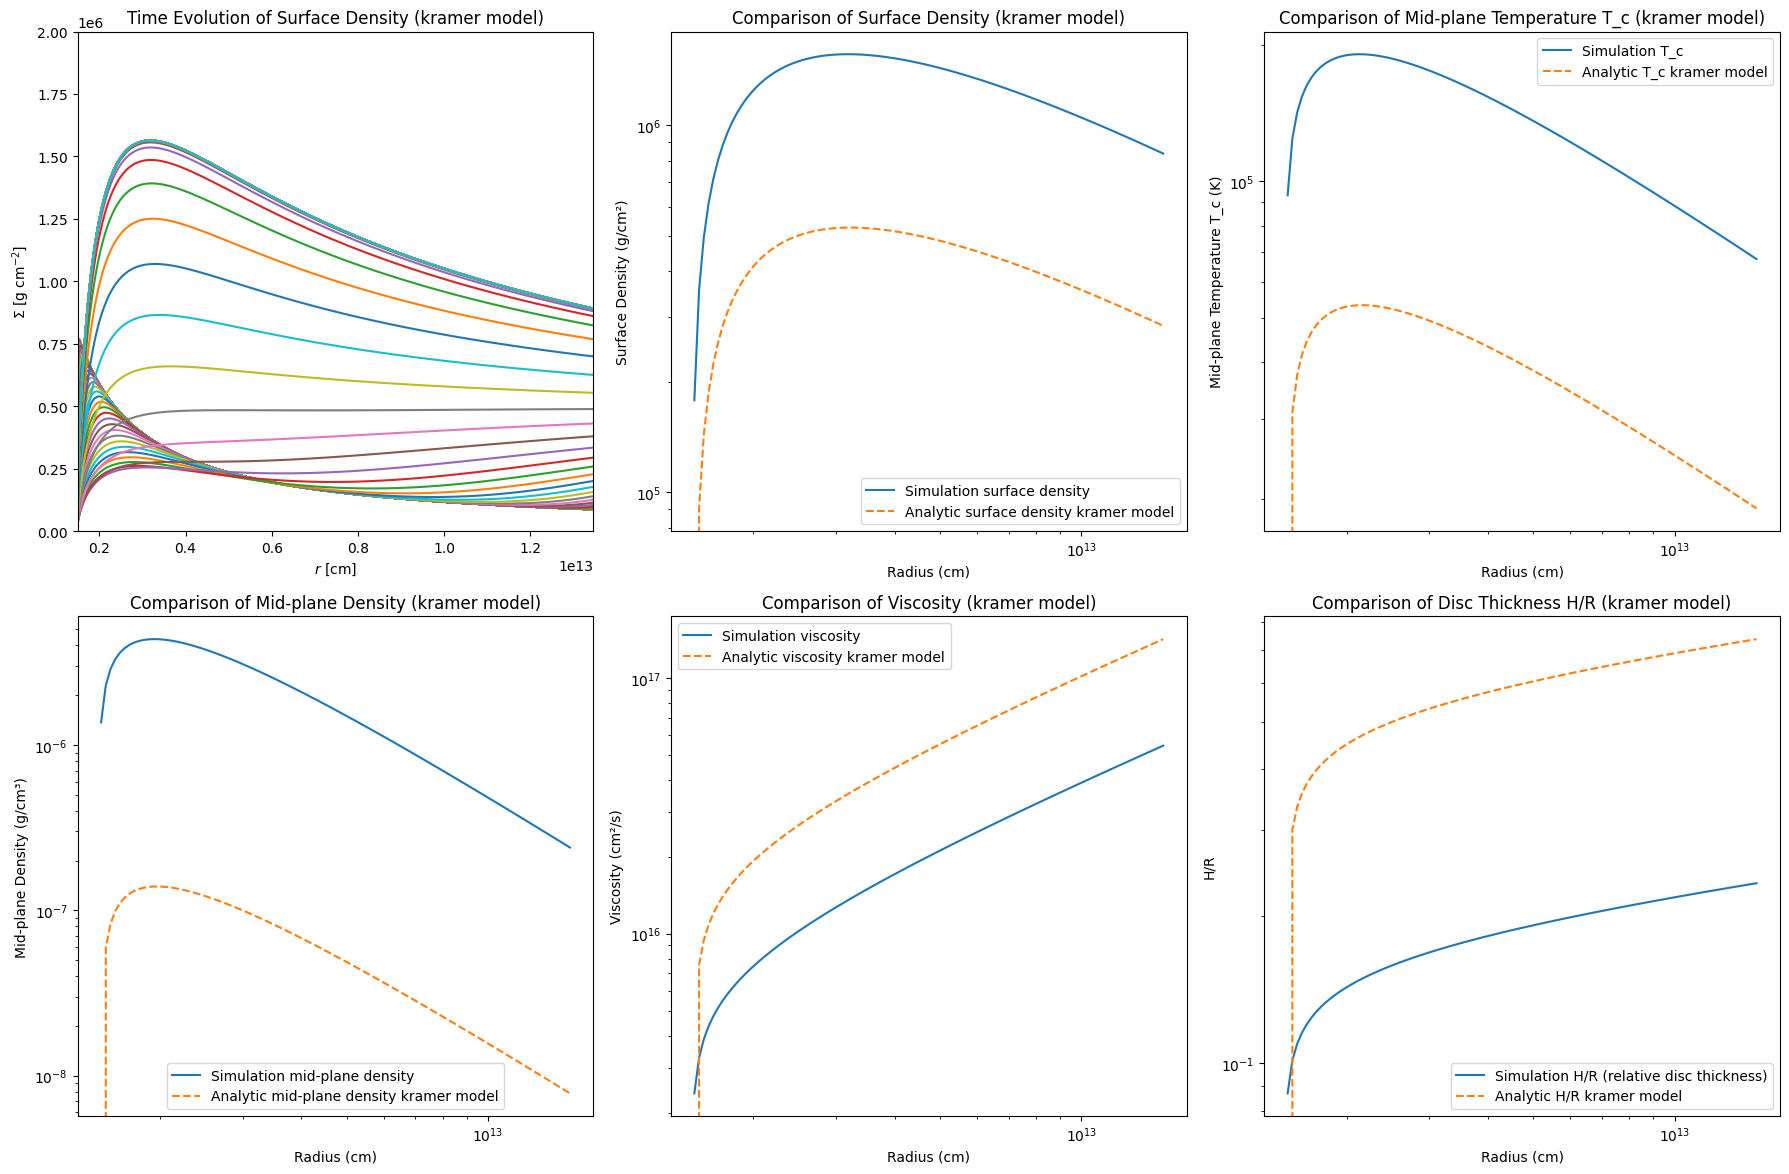

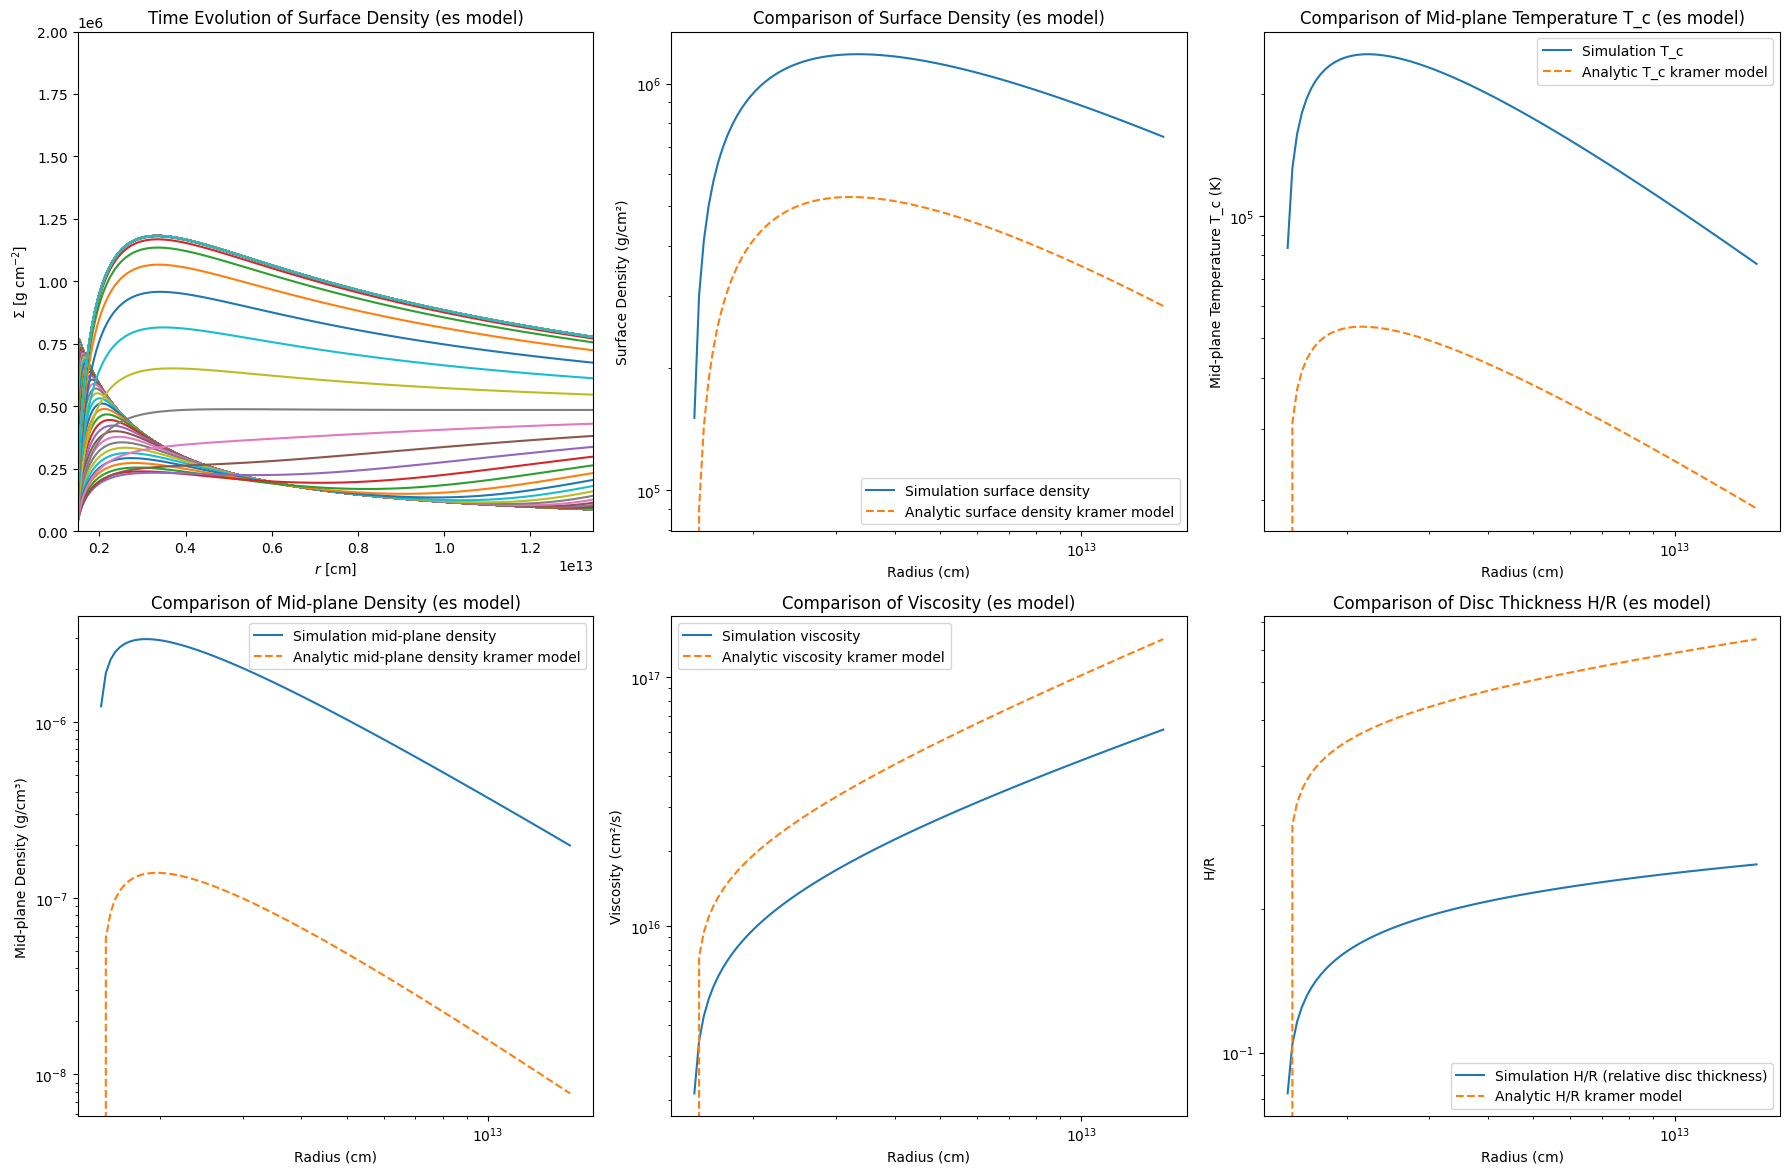

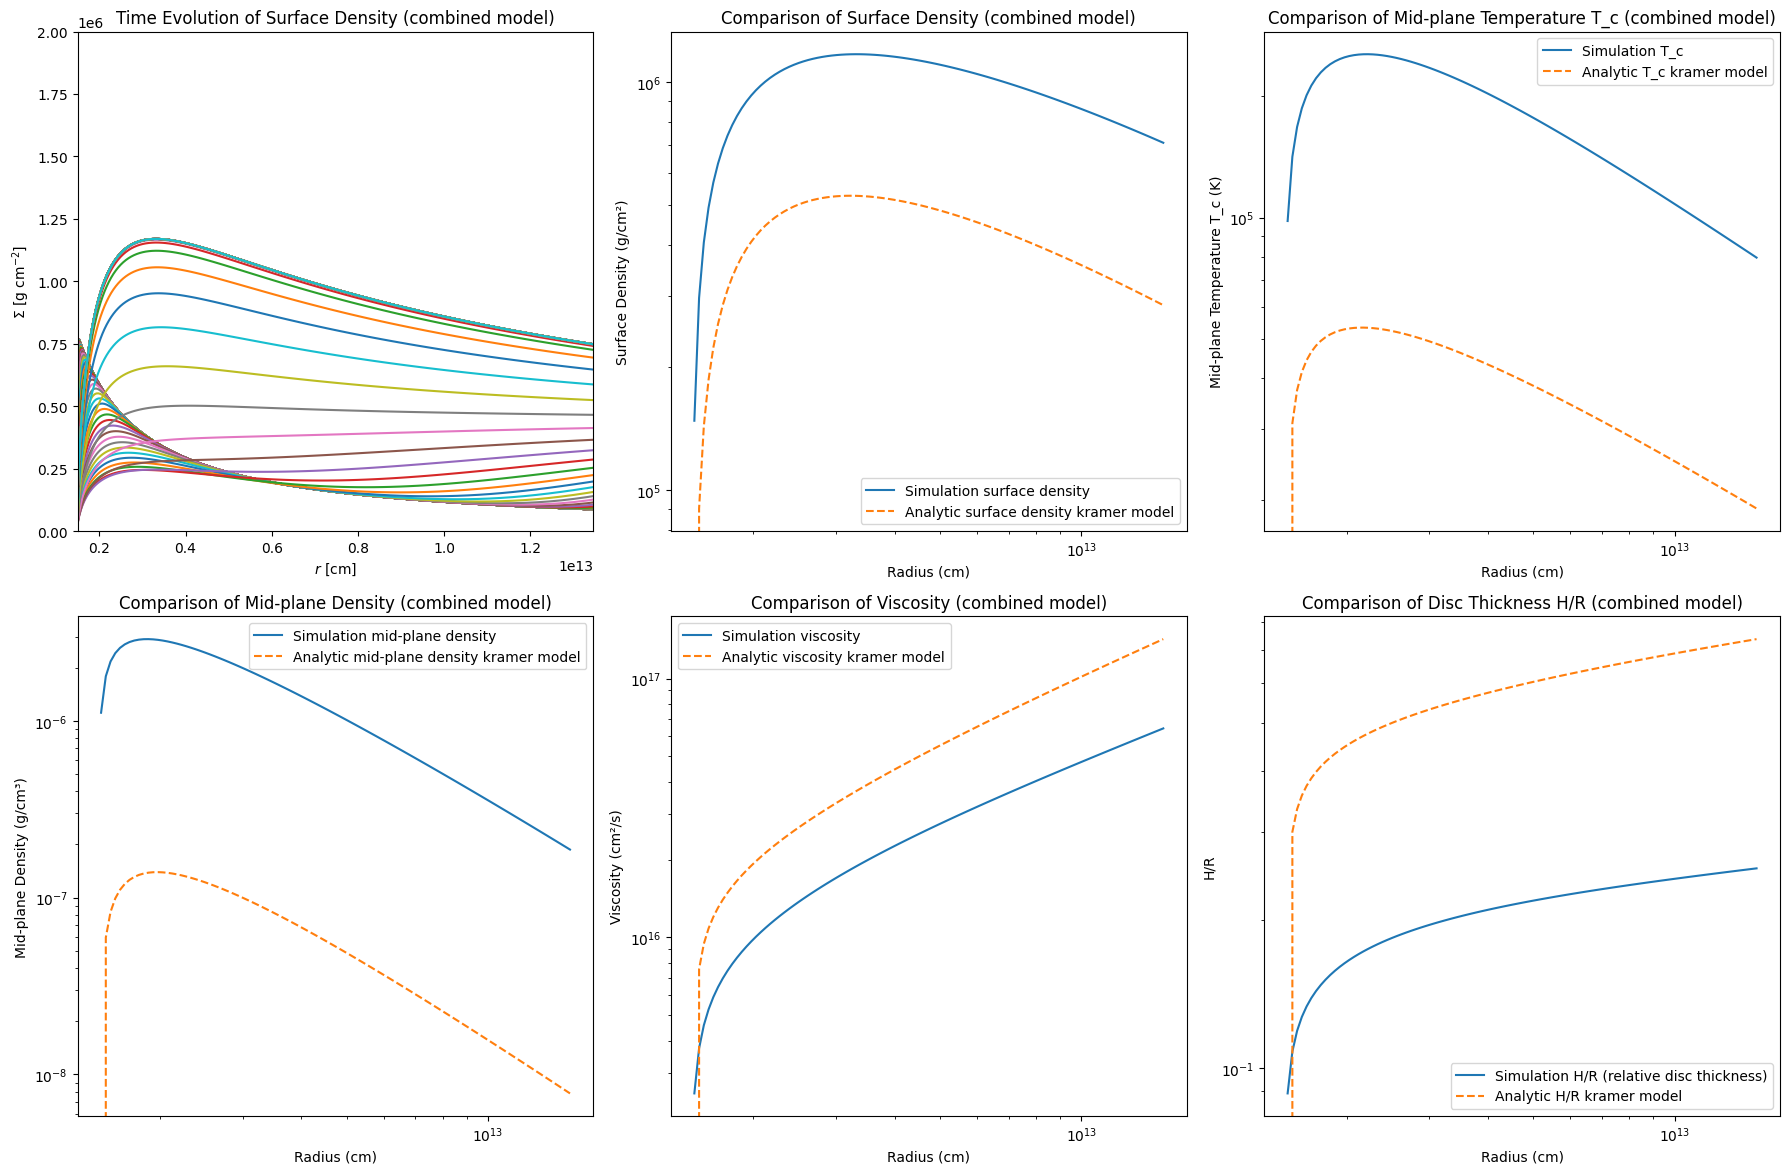

In [3]:
opacity_models = ['kramer', 'es', 'combined']

for model in opacity_models:
    # Initialize the disk model with the specified parameters
    d = DiskRadialModel(mstar = MBH, rin = R_in, rout = R_out, alpha = alpha_num)
    d.make_disk_from_m_pl(mdisk=0.01 * MBH)
    d.mu = 0.615

    d.meanopacitymodel = [model]
    d.compute_mean_opacity()
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=100)
    
    for i in range(1, ntime + 1):
        d.compute_nu()
        d.sigma = d.get_viscous_evolution_next_timestep(time_steps[i] - time_steps[i - 1], sigma_innerbc=d.sigma[1]/2, alphamodel=True, mdot_outerbc=0.01*MS/year)
        
        d.compute_disktmid(vischeat=True, simple=True)
        d.compute_cs_and_hp()
        d.compute_rhomid_from_sigma()
        d.compute_mean_opacity()
        axs[0, 0].plot(d.r, d.sigma, label=f'Time = {time_steps[i]:.1e} s')
    
    # Plotting surface density evolution
    axs[0, 0].set_xlabel(r'$r$ [cm]')
    axs[0, 0].set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
    axs[0, 0].set_title(f'Time Evolution of Surface Density ({model} model)')
    axs[0, 0].set_xlim(0.1*AU, 0.9*AU)
    axs[0, 0].set_ylim(0, 2e6)
    
    # Plot surface density
    axs[0, 1].loglog(d.r, d.sigma, label="Simulation surface density")
    axs[0, 1].loglog(d.r, Sigma_analytic(d.r), '--', label="Analytic surface density kramer model")
    axs[0, 1].set_xlabel("Radius (cm)")
    axs[0, 1].set_ylabel("Surface Density (g/cm²)")
    axs[0, 1].legend()
    axs[0, 1].set_title(f"Comparison of Surface Density ({model} model)")

    # Plot mid-plane temperature
    axs[0, 2].loglog(d.r, d.tmid, label="Simulation T_c")
    axs[0, 2].loglog(d.r, Tc_analytic(d.r), '--', label="Analytic T_c kramer model")
    axs[0, 2].set_xlabel("Radius (cm)")
    axs[0, 2].set_ylabel("Mid-plane Temperature T_c (K)")
    axs[0, 2].legend()
    axs[0, 2].set_title(f"Comparison of Mid-plane Temperature T_c ({model} model)")

    # Plot mid-plane density
    axs[1, 0].loglog(d.r, d.rhomid, label="Simulation mid-plane density")
    axs[1, 0].loglog(d.r, rho_analytic(d.r), '--', label="Analytic mid-plane density kramer model")
    axs[1, 0].set_xlabel("Radius (cm)")
    axs[1, 0].set_ylabel("Mid-plane Density (g/cm³)")
    axs[1, 0].legend()
    axs[1, 0].set_title(f"Comparison of Mid-plane Density ({model} model)")

    # Plot viscosity
    axs[1, 1].loglog(d.r, d.nu, label="Simulation viscosity")
    axs[1, 1].loglog(d.r, nu_analytic(d.r), '--', label="Analytic viscosity kramer model")
    axs[1, 1].set_xlabel("Radius (cm)")
    axs[1, 1].set_ylabel("Viscosity (cm²/s)")
    axs[1, 1].legend()
    axs[1, 1].set_title(f"Comparison of Viscosity ({model} model)")

    # Plot H/R (relative disc thickness)
    axs[1, 2].loglog(d.r, d.hp/d.r, label="Simulation H/R (relative disc thickness)")
    axs[1, 2].loglog(d.r, Hr_R_analytic(d.r), '--', label="Analytic H/R kramer model")
    axs[1, 2].set_xlabel("Radius (cm)")
    axs[1, 2].set_ylabel("H/R")
    axs[1, 2].legend()
    axs[1, 2].set_title(f"Comparison of Disc Thickness H/R ({model} model)")

    plt.tight_layout()
    plt.show()
    

## Opacity Transition in the Combined Model

A central aspect of this project is to investigate how the disk behaves when both free–free and electron scattering opacities are taken into account. The goal is to explore a region in parameter space where the disk transitions from being dominated by free–free opacity in its outer, cooler regions to being dominated by electron scattering opacity in its inner, hotter regions. 

In our simulations we explored how varying the mass accretion rate $\dot{M}$ affects the location of the opacity transition within the disk. At lower accretion rates, the disk remains relatively cooler, so the free–free opacity, which scales as $T^{-7/2}$, tends to dominate over a larger portion of the disk, causing the transition to occur closer to the inner edge. As $\dot{M}$ increases, the enhanced viscous heating raises the mid–plane temperature, making electron scattering (with its constant value of approximately $0.2\,(1+X)$, whith $X=0.7$) more important in the inner regions. By gradually increasing $\dot{M}$, we identified a parameter regime in which the transition radius, where the combined minus the electron scatering opacity equals the electron scattering opacity, lies in the middle of the disk. The combined minus the electron scatering opacity is not equal to the free-free opacity since the combined opacity is computed using the local disk conditions (density and temperature) that are themselves affected by the opacity prescription, our method will however give us the moment that for the combined opacity model the tranistion of dominant opacity occurs. In this mixed regime, the inner half of the disk is mostly governed by electron scattering—resulting in a higher mid–plane temperature and a slightly altered surface density profile—while the outer half follows the free–free scaling. This outcome shows how sensitive the disk structure is to the accretion rate.

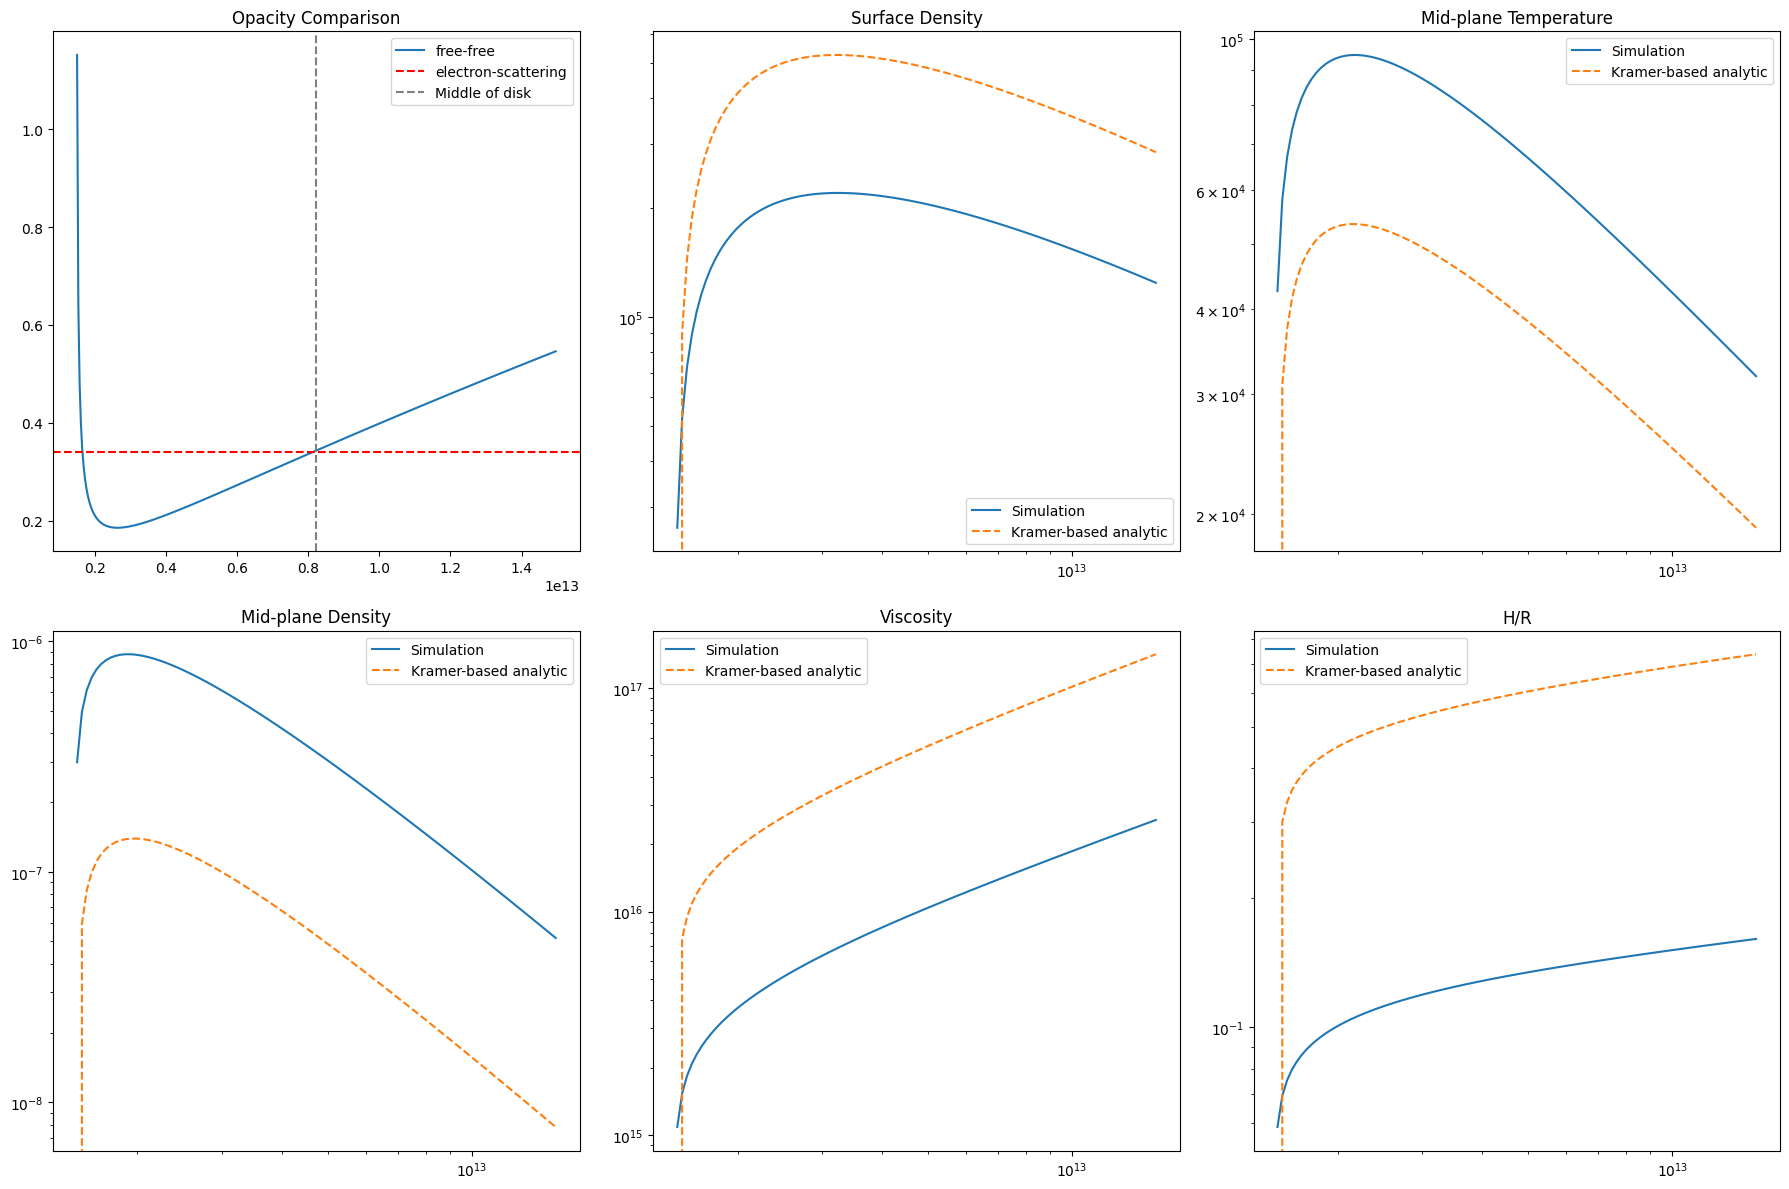

In [ ]:
# use mock opacity law and find opacity transition in middle of disk 
kappa_es = 0.2 * (1 + 0.7)


t_start = 1e-3
t_end = 1.5e5 * year                                              
n_points = 100
time = t_end**(np.linspace(0., 1., n_points + 1))

opacity = 'combined'

d = DiskRadialModel(mstar=MBH, rin=R_in, rout=R_out, alpha=alpha_num)
d.make_disk_from_m_pl(mdisk = 0.01*MBH)
d.meanopacitymodel=[opacity]
d.compute_mean_opacity()

for itime in range(1, n_points + 1):
    d.compute_nu()
    d.sigma = d.get_viscous_evolution_next_timestep(
        time[itime] - time[itime - 1], sigma_innerbc=d.sigma[1]/2,
        alphamodel=True, mdot_outerbc=7e-4*MS/year)

    d.compute_disktmid(vischeat=True, simple=True)
    d.compute_cs_and_hp()
    d.compute_rhomid_from_sigma()
    d.compute_mean_opacity()

fig2, axs2 = plt.subplots(2, 3, figsize=(18, 12), dpi=100)

axs2[0,0].plot(d.r, d.mean_opacity_rosseland - kappa_es, label='free-free')
axs2[0,0].axhline(y=kappa_es, color='red', linestyle='--', label='electron-scattering')
axs2[0,0].axvline(x=(np.max(d.r) + np.min(d.r))/2, linestyle='--', color='grey', label='Middle of disk')
axs2[0,0].legend()
axs2[0,0].set_title("Opacity Comparison")
    
# Compare final snapshot to analytic kramer-based profiles
axs2[0, 1].loglog(d.r, d.sigma, label="Simulation")
axs2[0, 1].loglog(d.r, Sigma_analytic(d.r), '--', label="Kramer-based analytic")
axs2[0, 1].legend()
axs2[0, 1].set_title("Surface Density")

axs2[0, 2].loglog(d.r, d.tmid, label="Simulation")
axs2[0, 2].loglog(d.r, Tc_analytic(d.r), '--', label="Kramer-based analytic")
axs2[0, 2].legend()
axs2[0, 2].set_title("Mid-plane Temperature")

axs2[1, 0].loglog(d.r, d.rhomid, label="Simulation")
axs2[1, 0].loglog(d.r, rho_analytic(d.r), '--', label="Kramer-based analytic")
axs2[1, 0].legend()
axs2[1, 0].set_title("Mid-plane Density")

axs2[1, 1].loglog(d.r, d.nu, label="Simulation")
axs2[1, 1].loglog(d.r, nu_analytic(d.r), '--', label="Kramer-based analytic")
axs2[1, 1].legend()
axs2[1, 1].set_title("Viscosity")

axs2[1, 2].loglog(d.r, d.hp / d.r, label="Simulation")
axs2[1, 2].loglog(d.r, Hr_R_analytic(d.r), '--', label="Kramer-based analytic")
axs2[1, 2].legend()
axs2[1, 2].set_title("H/R")

plt.tight_layout()
plt.show()


## Discussion and Conclusion

The results of Computing Set 2 confirm that the disk evolves toward a steady state that is in close agreement with the analytic solution derived from the conservation equations, as presented in the course notes and in FKR. The surface density, along with the radial profiles of temperature, density, viscosity, and disk thickness, all follow the expected power–law scalings with only differences in amplitude. These amplitude differences can be attributed to several factors. First, there are slight differences in the opacity constants and the treatment of factors such as the Gaunt factor, metallicity, and hydrogen fraction, which affect the normalization of the opacity. Second, the boundary conditions and the inner–edge treatment in the simulation may differ subtly from those assumed in the analytic derivations, leading to a vertical offset in the disk variables. Third, small variations in the chosen global parameters, such as the $\alpha$–viscosity parameter and the mass accretion rate, result in shifts in the amplitude of the computed quantities. Fourth, the assumed values for metallicity and helium fraction in the simulation can cause further differences in the free–free opacity and hence in the radiative cooling rate. Overall, even though there is a vertical offset between the numerical and analytic profiles, the fact that the radial power–law slopes match confirms that the simulation accurately reproduces the underlying physics. (see coursenotes 5,6,9)

All quantities are computed in cgs units, and the choices made for timesteps and boundary conditions ensure that the simulation remains stable and converges appropriately, in full accordance with the guidelines provided in the course notes and in talks with the TAs.